In [135]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection
from sklearn.inspection import permutation_importance

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np
import matplotlib

In [27]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [28]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [29]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [30]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [31]:
df = get_samples(df,100000)

In [32]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [33]:
df.shape

(100000, 4)

In [34]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer
df['polarity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### In this part, I wanted to see how subjective or polar the questions are for each category

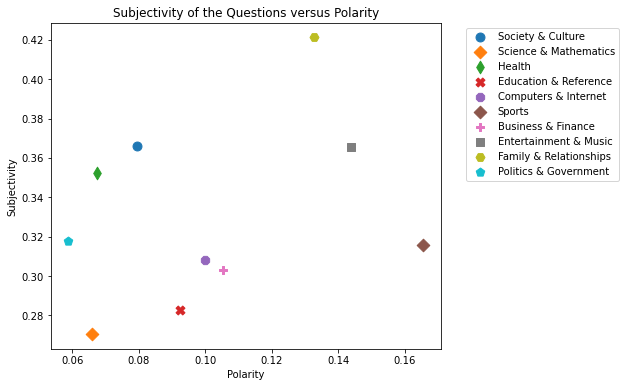

In [35]:
filled_markers = ('o', 'D', 'd', 'X','8', 'D','P','s','H', 'p')
fig,ax = plt.subplots(figsize=(7,6))
for i in range(1,11):
     ax.scatter(df[df.target==i]['polarity'].mean(),df[df.target==i]['subjectivity'].mean(),
                marker=filled_markers[i-1],label=target_classes[i-1],s=80,);

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
ax.set_xlabel('Polarity');
ax.set_ylabel('Subjectivity');
ax.set_title('Subjectivity of the Questions versus Polarity');

### In this section, I'm interested to see how many of the following words have been used in the sentence
* what
* how
* I
* is
* why
* can
* do
* does
* where
* my

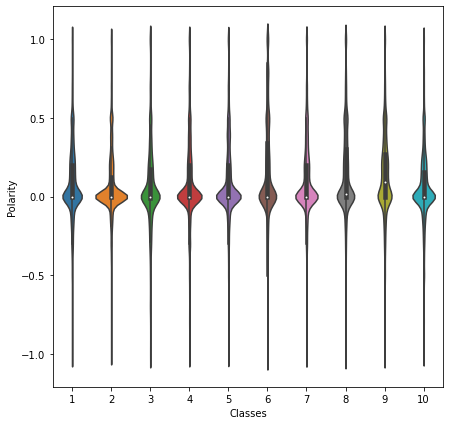

In [36]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='polarity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Polarity');
matplotlib.rcParams.update({'font.size': 14})

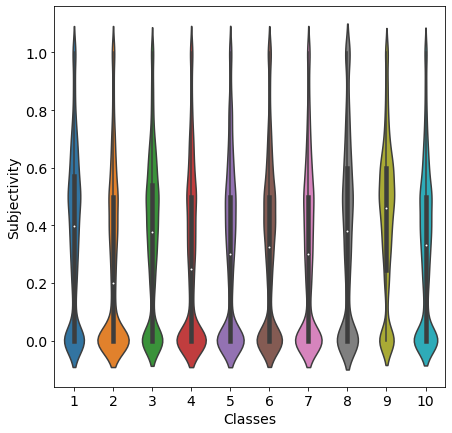

In [37]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='subjectivity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Subjectivity');
matplotlib.rcParams.update({'font.size': 14})

In [38]:
df['what']= df['Q'].apply(lambda x:len(re.findall('what',str(x).lower())))
df['how'] = df['Q'].apply(lambda x:len(re.findall('how',str(x).lower())))
df['am']  = df['Q'].apply(lambda x:len(re.findall('am',str(x).lower())))
df['is']  = df['Q'].apply(lambda x:len(re.findall('is',str(x).lower())))
df['are'] = df['Q'].apply(lambda x:len(re.findall('are',str(x).lower())))
df['why'] = df['Q'].apply(lambda x:len(re.findall('why',str(x).lower())))
df['can'] = df['Q'].apply(lambda x:len(re.findall('can',str(x).lower())))
df['do']= df['Q'].apply(lambda x:len(re.findall('do',str(x).lower())))
df['does']= df['Q'].apply(lambda x:len(re.findall('does',str(x).lower())))
df['where']= df['Q'].apply(lambda x:len(re.findall('where',str(x).lower())))
df['who']= df['Q'].apply(lambda x:len(re.findall('who',str(x).lower())))

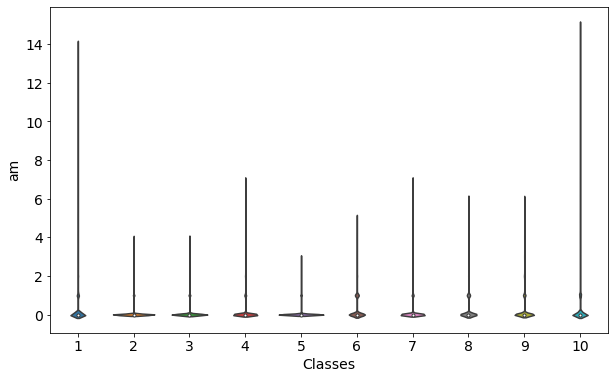

In [39]:
fig,axs = plt.subplots(figsize=(10,6));
axs = sns.violinplot(x='target',y='who', data=df , kind='swarm');
axs.set_xlabel('Classes');
axs.set_ylabel('am');
matplotlib.rcParams.update({'font.size': 14})

In [40]:
df.groupby('target')[['what','who','why','how','where']].mean().round(2)

,what,who,why,how,where
target,,,,,
1,0.49,0.19,0.26,0.25,0.08
2,0.45,0.04,0.13,0.32,0.07
3,0.45,0.06,0.10,0.31,0.05
4,0.47,0.08,0.08,0.24,0.09
5,0.30,0.04,0.07,0.50,0.10
6,0.29,0.24,0.09,0.19,0.08
7,0.41,0.09,0.08,0.31,0.10
8,0.41,0.21,0.09,0.22,0.11
9,0.54,0.16,0.16,0.37,0.06


In [41]:
target_classes_dict

{1: 'Society & Culture',
 2: 'Science & Mathematics',
 3: 'Health',
 4: 'Education & Reference',
 5: 'Computers & Internet',
 6: 'Sports',
 7: 'Business & Finance',
 8: 'Entertainment & Music',
 9: 'Family & Relationships',
 10: 'Politics & Government'}

In [42]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who
975506,3,Does man at risk in breast cancer?,,"Anyone can get breast cancer, including men......",Does man at risk in breast cancer?,Does man at risk in breast cancer?Anyone can g...,0.00,0.00,0,0,0,1,0,0,1,1,1,0,0
260379,10,Who is the president of Cambodia?,,King Norodom Sihamoni,Who is the president of Cambodia?,Who is the president of Cambodia?King Norodom ...,0.00,0.00,0,0,1,1,0,0,0,0,0,0,1
383216,2,Time dilation equations?,Are there any equations or web sites that desc...,"According to Einstein, all time is relative, a...",Time dilation equations?Are there any equation...,Time dilation equations?Are there any equation...,0.00,0.50,0,2,0,0,1,0,1,1,1,0,0
1211153,10,whos thinks the army cool?,,Both my brothers where Army. My two sisters wh...,whos thinks the army cool?,whos thinks the army cool?Both my brothers whe...,0.35,0.65,0,0,0,0,0,0,0,0,0,0,1
190731,7,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,,Prove it,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,0.00,0.00,0,0,0,2,0,0,0,0,0,0,0


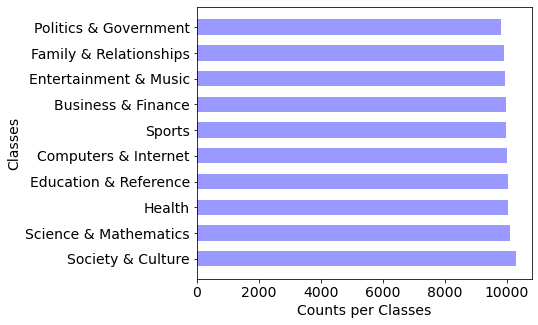

In [43]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [44]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [45]:
lst_stopwords = stopwords.words('english')+['else',"ya"]

In [46]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [47]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [48]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who,Text_new
975506,3,Does man at risk in breast cancer?,,"Anyone can get breast cancer, including men......",Does man at risk in breast cancer?,Does man at risk in breast cancer?Anyone can g...,0.00,0.00,0,0,0,1,0,0,1,1,1,0,0,man risk breast cancer anyone get breast cance...
260379,10,Who is the president of Cambodia?,,King Norodom Sihamoni,Who is the president of Cambodia?,Who is the president of Cambodia?King Norodom ...,0.00,0.00,0,0,1,1,0,0,0,0,0,0,1,president cambodia king norodom sihamoni
383216,2,Time dilation equations?,Are there any equations or web sites that desc...,"According to Einstein, all time is relative, a...",Time dilation equations?Are there any equation...,Time dilation equations?Are there any equation...,0.00,0.50,0,2,0,0,1,0,1,1,1,0,0,time dilation equation equation web site descr...
1211153,10,whos thinks the army cool?,,Both my brothers where Army. My two sisters wh...,whos thinks the army cool?,whos thinks the army cool?Both my brothers whe...,0.35,0.65,0,0,0,0,0,0,0,0,0,0,1,who think army cool brother army two sister ai...
190731,7,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,,Prove it,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,is this a question?!?!?!?!?!?!?!?!?!?!?!?!?!?!...,0.00,0.00,0,0,0,2,0,0,0,0,0,0,0,question prove


In [49]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [50]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,...,do,does,where,who,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
975506,3,Does man at risk in breast cancer?,,"Anyone can get breast cancer, including men......",Does man at risk in breast cancer?,Does man at risk in breast cancer?Anyone can g...,0.0,0.0,0,0,...,1,1,0,0,man risk breast cancer anyone get breast cance...,382,1839,26,4.814136,14.692308
260379,10,Who is the president of Cambodia?,,King Norodom Sihamoni,Who is the president of Cambodia?,Who is the president of Cambodia?King Norodom ...,0.0,0.0,0,0,...,0,0,0,1,president cambodia king norodom sihamoni,8,47,1,5.875000,8.000000


In [51]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

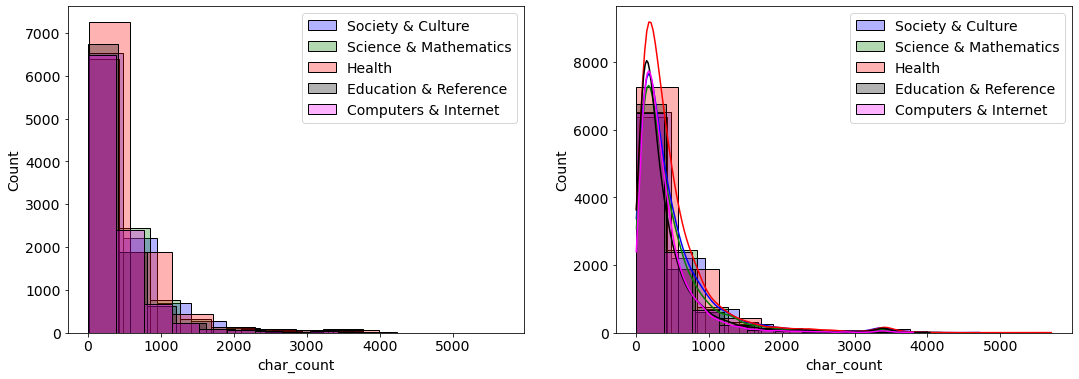

In [52]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [53]:
df.groupby('target').word_count.median()

target
1     71
2     65
3     76
4     52
5     60
6     45
7     53
8     40
9     75
10    74
Name: word_count, dtype: int64

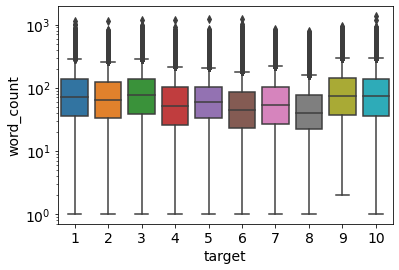

In [54]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

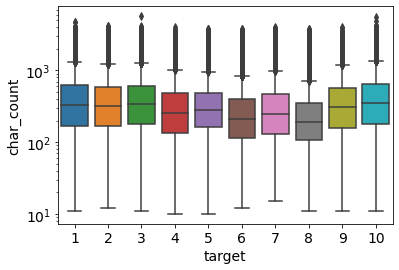

In [55]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

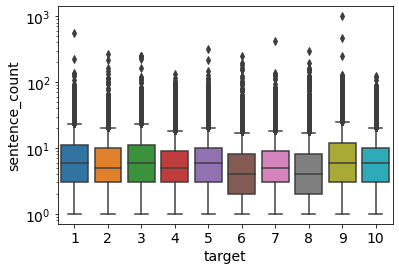

In [56]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

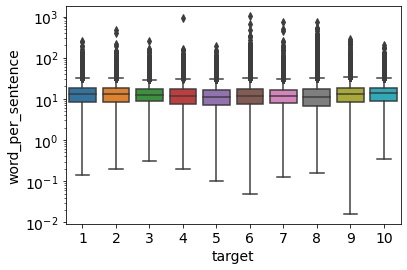

In [57]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [58]:
X = df.Text_new
y = df.target

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [60]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [61]:
XX_train = vect.fit_transform(X_train)

In [62]:
XX_test = vect.transform(X_test)

In [63]:
vocab = vect.vocabulary_

In [64]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [65]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

7641

In [66]:
df_features.head(5)

,feature,Score,y
263,agnostic,1.0,1
305,allah,1.0,1
653,atheist,1.0,1
865,belief,1.0,1
867,believe,1.0,1


In [67]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 1267
agnostic,allah,atheist,belief,believe,believe god,believer,believing,bible,bible say,catholic,catholic church,christ,christian,christianity,christmas,church,commandment,culture,eternal,evil,faith,gay,go heaven,go hell,god,god god,gospel,heaven,hell

category 2: Science & Mathematics
length of category 2: 1991
2x,2y,3x,4x,5x,acceleration,acid,air,altitude,angle,animal,aq,atmosphere,atom,atomic,axis,bacteria,big bang,biology,black hole,boiling,calculate,carbon,carbon dioxide,cell,chemical,chemistry,chloride,chromosome,cloud

category 3: Health
length of category 3: 1841
ab,abdominal,abnormal,ache,acne,allergic,allergy,antibiotic,anxiety,artery,ask doctor,asthma,avoid,back pain,bipolar,birth control,bladder,bleeding,blood,blood pressure,blood sugar,blood test,body,bone,bowel,brace,breast,breast cancer,bump,caffeine

category 4: Education & Reference
length of category 4: 932
admission,bachelor,book,class,classroom,college,community 

In [68]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [69]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(90000, 7641)

In [70]:
XX_test = vect.transform(X_test)

In [71]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [72]:
# Creating a cloud of words

In [73]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [74]:
Text = " ".join(df_features[df_features.y==10].feature[:30])
Text

'administration afghanistan air force amendment america american american citizen amnesty army arrest arrested attack attorney ballot bill bin laden bomb border bush campaign canada candidate cheney china citizen citizenship civil civilian clinton communism'

In [75]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

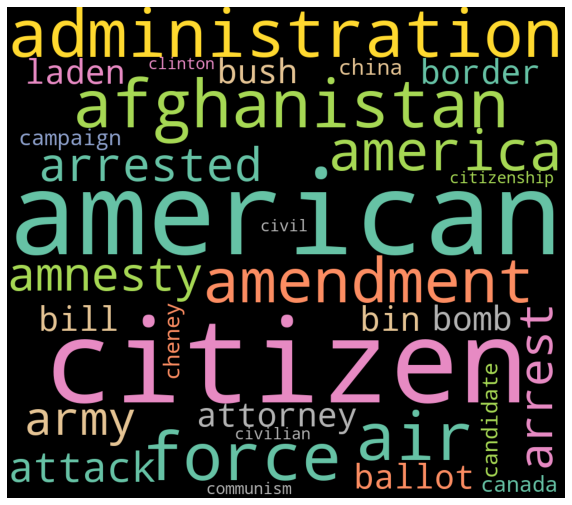

In [76]:
plot_cloud(wordcloud)

In [77]:
# cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [78]:
# X_train_cvec = cvec.fit_transform(X_train)
# X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [79]:
nb = naive_bayes.MultinomialNB()

In [80]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [81]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6747000000000001

In [82]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [83]:
## Test Classifier
Predicted_nb = nb.predict(XX_test)
Predicted_prob_nb = nb.predict_proba(XX_test)

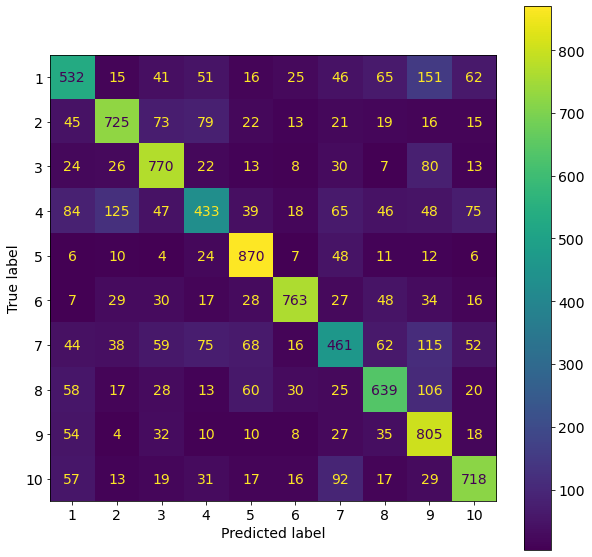

In [84]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

## Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [85]:
model_lr = LogisticRegression(max_iter=5000,n_jobs=-1)

In [86]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [87]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6818111111111111

In [88]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000, n_jobs=-1)

In [89]:
## Test Classifier
Predicted_lr = model_lr.predict(XX_test)
Predicted_prob_lr = model_lr.predict_proba(XX_test)

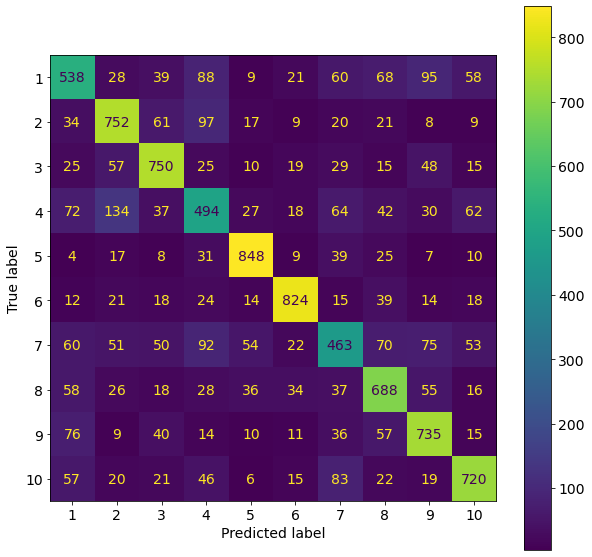

In [90]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

In [91]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted_lr)
auc = roc_auc_score(y_test,Predicted_prob_lr,multi_class='ovr')

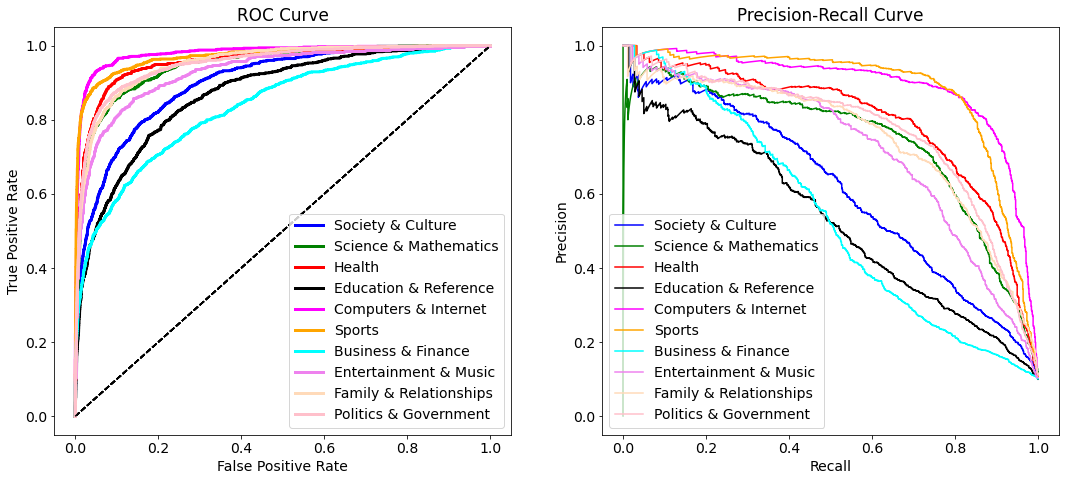

In [92]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()

In [93]:
def logreg_coef_importance(fit_logreg, tvectorizer):
    feature_names = tvectorizer.get_feature_names()
    coef_matrix = lr.coef_
    dict_list = []
    for coef_row in coef_matrix:
        print(coef_row)
        d = {}
        for coef, feature_name in zip(coef_row, feature_names):
            d[feature_name] = coef

        sorted_values = list(reversed(sorted(d.values()))) # Sort the values
        sorted_dict = {}
        for i in sorted_values:
            for k in d.keys():
                if d[k] == i:
                    sorted_dict[k] = d[k]
                    break
        dict_list.append(sorted_dict)

    return dict_list

In [94]:
feature_names = vect.get_feature_names()
coef_matrix = model_lr.coef_
dict_list=[]
for coef_row in coef_matrix:
    d={}
    for coef,fname in zip(coef_row,feature_names):
        d[fname] = coef
    sorted_values = list(reversed(sorted(d.values())))
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k]==i:
                sorted_dict[k]=d[k]
                break
    dict_list.append(sorted_dict)




In [173]:
def logistic_importance(ax,data,n_features,title):
    '''
    input: data : dictionary for the purpose of visualization
           ax : ax-object
    '''
    temp_data ={keys:values for (keys,values) in [x for x in data.items()][:n_features]}
    ax.barh(list(temp_data.keys()),list(temp_data.values()),color='g',alpha=0.4)
    ax.set_xlabel('Beta Coefficient')
    ax.set_ylabel('Feature Importance')
    ax.set_title(title)
    ax.invert_yaxis()

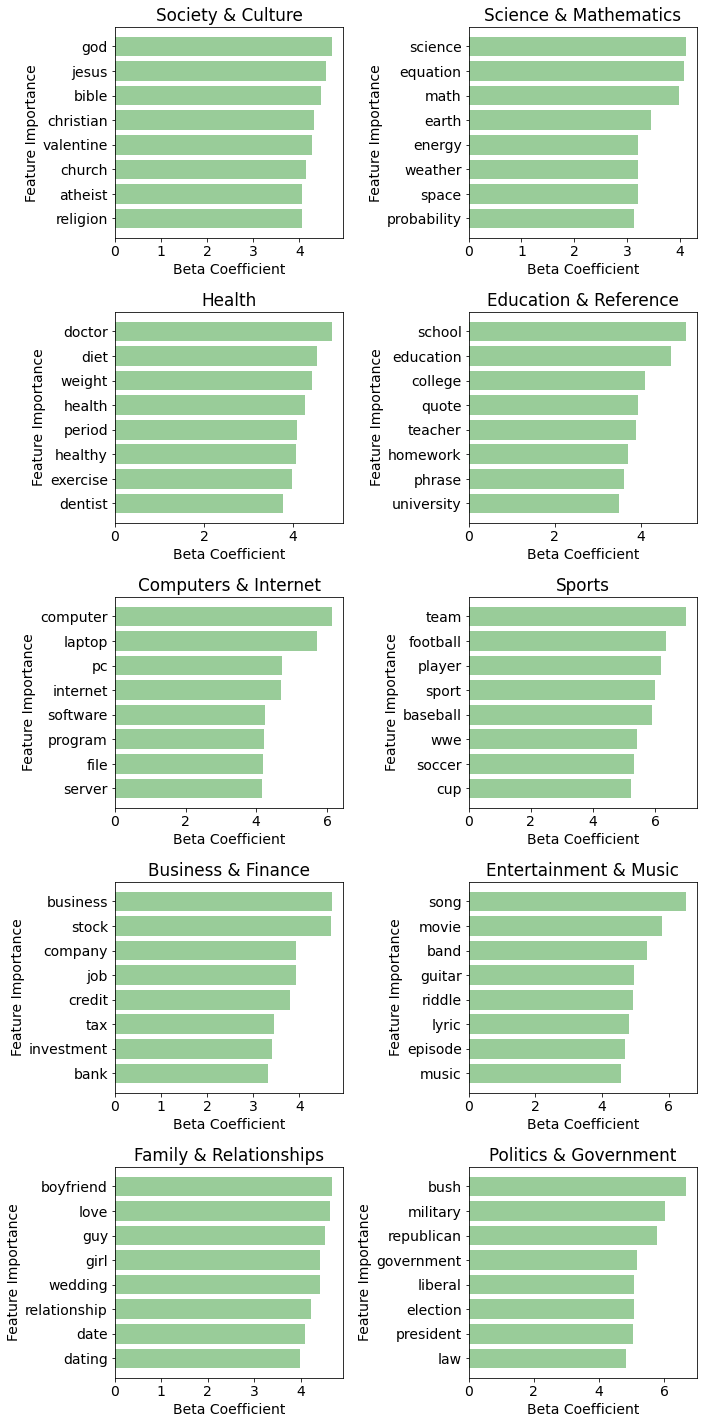

In [174]:
fig,axs = plt.subplots(5,2,figsize=(10,20))
n_features = 8
for i,ax in enumerate(axs.ravel()):
    logistic_importance(ax,dict_list[i],n_features,target_classes[i])
fig.tight_layout()

In [189]:
data = dict_list[6]
temp_data ={keys for (keys,values) in [x for x in data.items()][:20]}
Text = " ".join(temp_data)
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

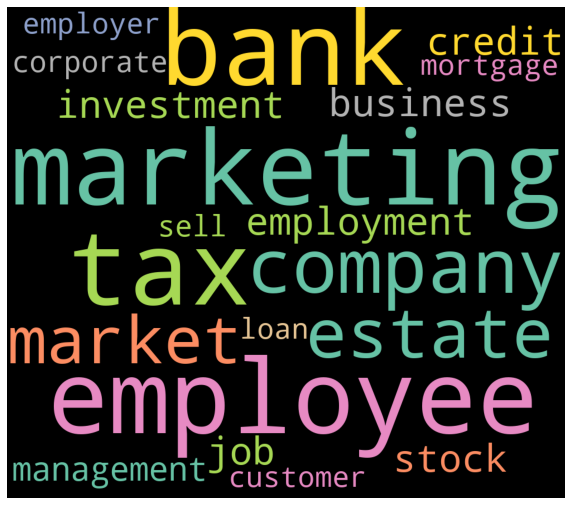

In [190]:
plot_cloud(wordcloud)

In [97]:
print(classification_report(y_test,Predicted_lr,target_names=target_classes))

                        precision    recall  f1-score   support

     Society & Culture       0.57      0.54      0.55      1004
 Science & Mathematics       0.67      0.73      0.70      1028
                Health       0.72      0.76      0.74       993
 Education & Reference       0.53      0.50      0.51       980
  Computers & Internet       0.82      0.85      0.84       998
                Sports       0.84      0.82      0.83       999
    Business & Finance       0.55      0.47      0.50       990
 Entertainment & Music       0.66      0.69      0.67       996
Family & Relationships       0.68      0.73      0.70      1003
 Politics & Government       0.74      0.71      0.73      1009

              accuracy                           0.68     10000
             macro avg       0.68      0.68      0.68     10000
          weighted avg       0.68      0.68      0.68     10000



## Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [98]:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=20,max_depth=40,n_jobs=-1)

In [106]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [107]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6132222222222223

In [108]:
training_scores=[]
test_scores=[]
# for tree in tree_list:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=50,max_depth=300,n_jobs=-1)
model_rf.fit(XX_train,y_train)
training_scores.append(accuracy_score(y_train,model_rf.predict(XX_train)))
test_scores.append(accuracy_score(y_test,model_rf.predict(XX_test)))   

In [109]:
training_scores

[0.9932444444444445]

In [110]:
test_scores

[0.6291]

In [111]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

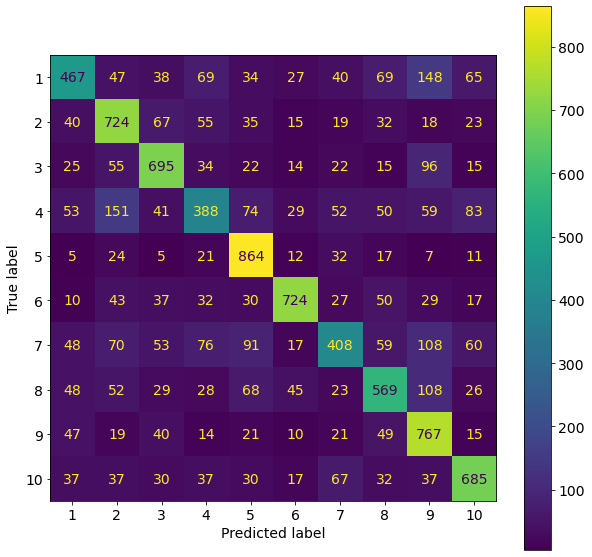

In [112]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

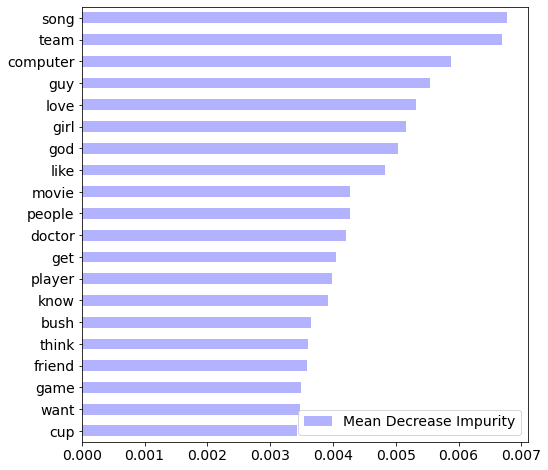

In [113]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')


Creating permutation would take a long time. You can create one by uncommenting the following lines

In [114]:
# results = permutation_importance(model_rf, XX_test.todense(), y_test, n_repeats=5, random_state=0)
# feature_scores = pd.DataFrame({'feature_importance_mean' : results.importances_mean}, index=feature_names)
# feature_scores = feature_scores.sort_values(by='feature_importance_mean', ascending=False)
# feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
# plt.gca().invert_yaxis()

## Gradient Boost

In [203]:
gb = GradientBoostingClassifier()

In [204]:
# cross_val_score(gb,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [205]:
# training_scores=[]
# test_scores=[]
# tree_list=[1000,1500]
# for tree in tree_list:
#     model_gb = GradientBoostingClassifier(n_estimators=tree,learning_rate=0.01)
#     model_gb.fit(XX_train,y_train)
#     training_scores.append(accuracy_score(y_train,model_gb.predict(XX_train)))
#     test_scores.append(accuracy_score(y_test,model_gb.predict(XX_test)))   

In [206]:
parameters = {'n_estimators':[500,1000,1500,2000],
              'learning_rate':[0.1,0.01]}

In [207]:
gb_tune = GridSearchCV(gb,param_grid=parameters,cv=2,scoring='accuracy',n_jobs=-1,verbose=2)

In [ ]:
gb_tune.fit(XX_train,y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


### Binary Classification

Tried to see how does binary classification works for one of the classes

In [ ]:
# y_train_binary = y_train.replace([1,2,3,4,6,7,8,9,10],0)
# y_train_binary = y_train_binary.replace(5,1)

In [2]:
# y_test_binary = y_test.replace([1,2,3,4,6,7,8,9,10],0)
# y_test_binary = y_test_binary.replace(5,1)
# y_test_binary.value_counts()

In [3]:
# model_lr = LogisticRegression(max_iter=5000,class_weight='balanced')

In [4]:
# cross_val_score(model_lr,XX_train,y_train_binary,cv=5,n_jobs=-1).mean()
# model_lr.fit(XX_train,y_train_binary)

In [5]:
# ## Test Classifier
# Predicted = model_lr.predict(XX_test)
# Predicted_prob = model_lr.predict_proba(XX_test)

In [23]:
# fig, ax = plt.subplots(figsize=(10, 10));
# plot_confusion_matrix(model_lr,XX_test,y_test_binary,ax=ax);

### GridSearch CV

In [97]:
# opt_model = pipeline.Pipeline([
#            ('vectopt', TfidfVectorizer()),
#            ('classifier', model_lr)])

In [98]:
# parameters = {
#     'vectopt__max_df': (0.98, 1.0),
#     'vectopt__min_df': (0.01, 0.02 ),
#     'vectopt__max_features': (2000, 5000, 10000),
#     'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
#                 }

In [99]:
# # lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=2,verbose=1,scoring='accuracy',n_jobs=-1)
# lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=50)

In [100]:
# lr_gs.fit(X_train,y_train)

In [101]:
# e = pd.DataFrame(lr_gs.cv_results_)

In [102]:
# e.sort_values(by='mean_test_score',axis=0,ascending=False)

### USE THE BELOW LINES FOR DEBUGGING

In [103]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [104]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([  71881,  250093,  131179,  196882,  948895,  816637,  228847,
            1137552,  145693,  975084,
            ...
            1259807,  614739, 1118605,  398211, 1271074,  181542, 1117585,
             202151,  569194,  973810],
           dtype='int64', length=2979)

In [105]:
X_test[(y_test!=Predicted) & (y_test==7)].index

Int64Index([  71881,  250093,  131179,  196882,  948895,  816637,  228847,
            1137552,  145693,  975084,
            ...
            1259807,  614739, 1118605,  398211, 1271074,  181542, 1117585,
             202151,  569194,  973810],
           dtype='int64', length=2979)

In [106]:
index_number = 43695

In [142]:
X_test.loc[index_number]

In [ ]:
df.loc[index_number]

In [ ]:
df.loc[index_number]['Q&A']

In [ ]:
vocab

In [ ]:
test_set = 55
text = X_test.iloc[test_set]
text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [ ]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [ ]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)

In [ ]:
text= 'This is ok '

In [ ]:
TextBlob(text).sentiment.polarity